In [97]:
# shapely: good for representing geometries
import rioxarray as r
# :  opening geo-data, processing its metadata
from shapely.geometry import MultiLineString
# osmnx: download data from OSM
import osmnx as ox
import rasterio
# pandas for geo-data, very useful
import geopandas as gpd
from osgeo import gdal, ogr, osr
import utm

import cv2
from pathlib import Path
import matplotlib.pyplot as plt


In [6]:
tif_path = Path('../out/swissimage-dop10_2022_2669-1259_0.1_2056.tif').resolve()
sentinel_path = Path('../S2B_MSIL2A_20190226T111049_N0211_R137_T30UXB_20190226T172349.SAFE/GRANULE/L2A_T30UXB_A010316_20190226T111048/IMG_DATA/R10m/T30UXB_20190226T111049_TCI_10m.jp2').resolve()

In [7]:
xds = r.open_rasterio(tif_path)

/home/gsa/anaconda3/envs/dl/lib/python3.10/site-packages/pyproj/crs/_cf1x8.py:511: UserWarning: angle from rectified to skew grid parameter lost in conversion to CF
  warnings.warn(


In [8]:
xds_s = r.open_rasterio(sentinel_path)

In [9]:
xds

<xarray.DataArray (band: 3, y: 10000, x: 10000)>
[300000000 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1 2 3
  * x            (x) float64 2.669e+06 2.669e+06 2.669e+06 ... 2.67e+06 2.67e+06
  * y            (y) float64 1.26e+06 1.26e+06 1.26e+06 ... 1.259e+06 1.259e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  2 (pixels/inch)
    TIFFTAG_XRESOLUTION:     0
    TIFFTAG_YRESOLUTION:     0
    scale_factor:            1.0
    add_offset:              0.0

In [10]:
xds_s

<xarray.DataArray (band: 3, y: 10980, x: 10980)>
[361681200 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1 2 3
  * x            (x) float64 6e+05 6e+05 6e+05 ... 7.098e+05 7.098e+05 7.098e+05
  * y            (y) float64 5.7e+06 5.7e+06 5.7e+06 ... 5.59e+06 5.59e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

# OSMNX
See sample notebooks [here](https://github.com/gboeing/osmnx-examples/blob/main/notebooks)

In [7]:
# get all building footprints in some neighborhood
place = "ETH Zurich"
tags = {"building": True}
gdf = ox.geometries_from_place(place, tags)
gdf.shape

(2, 19)

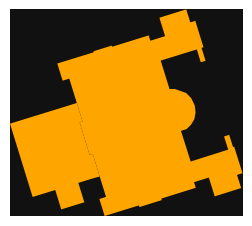

In [8]:
fig, ax = ox.plot_footprints(gdf, figsize=(3, 3))

In [9]:
gdf

wheelchair  \
element_type osmid                  
way          13952883         NaN   
             192151232    limited   

                                                                 geometry  \
element_type osmid                                                          
way          13952883   POLYGON ((8.54703 47.37592, 8.54710 47.37578, ...   
             192151232  POLYGON ((8.54840 47.37681, 8.54835 47.37679, ...   

                                                                    nodes  \
element_type osmid                                                          
way          13952883   [130254112, 130254113, 130254114, 638451198, 1...   
             192151232  [2027117351, 2027117347, 7619406453, 202711735...   

                       addr:housename addr:housenumber      addr:street  \
element_type osmid                                                        
way          13952883          ETH MM            34,36  Leonhardstrasse   
             192151232         ETH HG              101      Rämistrasse   

                          building building:levels   description layer  \
element_type osmid                                                       
way          13952883   university               1  Mensa / ASVZ    -1   
             192151232  university               4           NaN   NaN   

                       location                name:ko addr:postcode  amenity  \
element_type osmid                                                              
way          13952883   surface  취리히 연방공대 기계 & 재료공학 건물           NaN      NaN   
             192151232      NaN                    NaN          8092  college   

                       building:colour building:roof:colour isced:level  \
element_type osmid                                                        
way          13952883              NaN                  NaN         NaN   
             192151232         #e5c465              #443c39       6;7;8   

                              name   wikidata  
element_type osmid                             
way          13952883          NaN        NaN  
             192151232  ETH Zürich  Q14565994

In [10]:
gdf.columns

Index(['wheelchair', 'geometry', 'nodes', 'addr:housename', 'addr:housenumber',
       'addr:street', 'building', 'building:levels', 'description', 'layer',
       'location', 'name:ko', 'addr:postcode', 'amenity', 'building:colour',
       'building:roof:colour', 'isced:level', 'name', 'wikidata'],
      dtype='object')

In [11]:
gdf['geometry']

element_type  osmid    
way           13952883     POLYGON ((8.54703 47.37592, 8.54710 47.37578, ...
              192151232    POLYGON ((8.54840 47.37681, 8.54835 47.37679, ...
Name: geometry, dtype: geometry

In [12]:
gdf['building:roof:colour']

element_type  osmid    
way           13952883         NaN
              192151232    #443c39
Name: building:roof:colour, dtype: object

## Rasterio

{'type': 'Polygon', 'coordinates': [[[8.354178, 47.487144], [8.354023, 47.47815], [8.367289, 47.478045], [8.367446, 47.487038], [8.354178, 47.487144]]]}


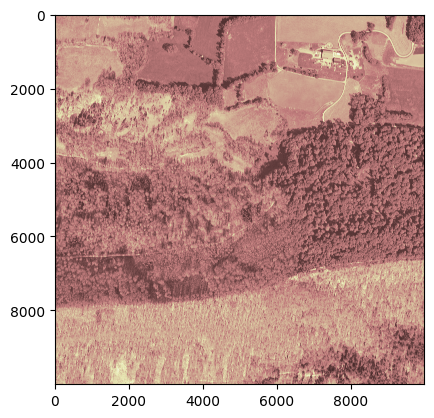

In [27]:
import rasterio
import rasterio.features
import rasterio.warp


with rasterio.open(tif_path) as dataset:

    # Read the dataset's valid data mask as a ndarray.
    mask = dataset.dataset_mask()

    # Extract feature shapes and values from the array.
    for geom, val in rasterio.features.shapes(
            mask, transform=dataset.transform):

        # Transform shapes from the dataset's own coordinate
        # reference system to CRS84 (EPSG:4326).
        geom = rasterio.warp.transform_geom(
            dataset.crs, 'EPSG:4326', geom, precision=6)

        # Print GeoJSON shapes to stdout.
        print(geom)
        
        plt.imshow(dataset.read(1), cmap='pink')        

In [14]:
help(dataset)

Help on DatasetReader in module rasterio.io object:

class DatasetReader(rasterio._io.DatasetReaderBase, rasterio.windows.WindowMethodsMixin, rasterio.transform.TransformMethodsMixin)
 |  An unbuffered data and metadata reader
 |  
 |  Method resolution order:
 |      DatasetReader
 |      rasterio._io.DatasetReaderBase
 |      rasterio._base.DatasetBase
 |      rasterio.windows.WindowMethodsMixin
 |      rasterio.transform.TransformMethodsMixin
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __repr__(self)
 |      Return repr(self).
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from rasterio._io.DatasetReaderBase:
 |  
 |  __reduce__ = __reduce_cython

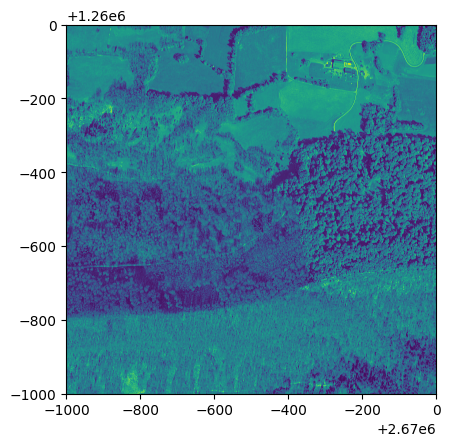

In [25]:
from rasterio.plot import show

with rasterio.open(tif_path) as dataset:
    show((dataset, 2))

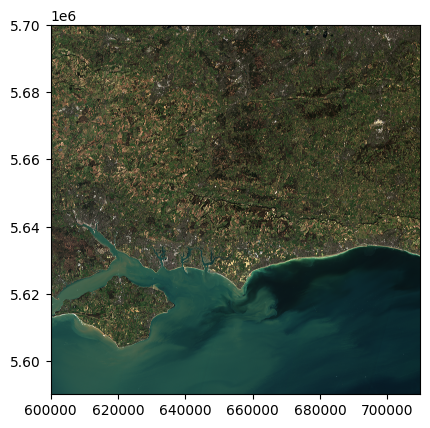

In [32]:
# same as qgis rendering
with rasterio.open(sentinel_path, driver='JP2OpenJPEG') as dataset:
    show(dataset)

In [34]:
data_sentinel = rasterio.open(sentinel_path, driver='JP2OpenJPEG')
data_tif = rasterio.open(tif_path)

In [62]:
data_tif.width, data_tif.height, data_sentinel.width, data_sentinel.height

(10000, 10000, 10980, 10980)

In [63]:
data_sentinel.crs, data_tif.crs

(CRS.from_epsg(32630), CRS.from_epsg(2056))

In [64]:
dir(data_sentinel)
# data_sentinel.meta


['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__pyx_vtable__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_block_shapes',
 '_closed',
 '_count',
 '_crs',
 '_crs_wkt',
 '_descriptions',
 '_dtypes',
 '_env',
 '_gcps',
 '_get_crs',
 '_get_rpcs',
 '_handle_crswkt',
 '_has_band',
 '_has_gcps_or_rpcs',
 '_mask_flags',
 '_nodatavals',
 '_offsets',
 '_read',
 '_rpcs',
 '_scales',
 '_set_all_descriptions',
 '_set_all_offsets',
 '_set_all_scales',
 '_set_all_units',
 '_set_attrs_from_dataset_handle',
 '_set_crs',
 '_set_gcps',
 '_set_nodatavals',
 '_set_rpcs',
 '_transform',
 '_units',
 'block_shapes',
 'block_size',
 'block_window',
 'block_windows',
 'bounds',
 'checksum

In [59]:
lon, lat = data_sentinel.lnglat()
print(f'Original lon, lat: {lon}, {lat}.')

# Spatial Reference System
inputEPSG = data_sentinel.crs.to_epsg()
outputEPSG = data_tif.crs.to_epsg()

# create a geometry from coordinates
point = ogr.Geometry(ogr.wkbPoint)
point.AddPoint(lon, lat)

# create coordinate transformation
inSpatialRef = osr.SpatialReference()
inSpatialRef.ImportFromEPSG(inputEPSG)

outSpatialRef = osr.SpatialReference()
outSpatialRef.ImportFromEPSG(outputEPSG)

coordTransform = osr.CoordinateTransformation(inSpatialRef, outSpatialRef)

# transform point
point.Transform(coordTransform)

# print point in EPSG dest
print(point.GetX(), point.GetY())


# convert back to src epsg

# create coordinate transformation
inSpatialRef = osr.SpatialReference()
inSpatialRef.ImportFromEPSG(outputEPSG)

outSpatialRef = osr.SpatialReference()
outSpatialRef.ImportFromEPSG(inputEPSG)

coordTransform = osr.CoordinateTransformation(inSpatialRef, outSpatialRef)

# transform point
point.Transform(coordTransform)

# print point in EPSG dest
print(point.GetX(), point.GetY())

Original lon, lat: -0.7953781382129271, 50.93669863140612.
232006.7468644511 -4376444.914548155
-0.7941948498482816 50.94139478722728


In [56]:
# help(data_sentinel.crs)
data_sentinel.crs.to_epsg(), data_sentinel.crs

(32630, CRS.from_epsg(32630))

# Patchify

In [11]:
from patchify import patchify

patch_size = 512

def make_patches(path, channels):
    flag = 1 if channels == 3 else 0
    image = cv2.imread(path, flag) 
    SIZE_X = (image.shape[1]//patch_size)*patch_size 
    SIZE_Y = (image.shape[0]//patch_size)*patch_size
    image = image[:SIZE_Y, :SIZE_X]       

    if channels == 3:
        patches_img = patchify(image, (patch_size, patch_size, channels), step=patch_size) 
        patches_img = np.reshape(patches_img, (-1, patch_size, patch_size, channels))
    else:
        patches_img = patchify(image, (patch_size, patch_size), step=patch_size)  
        patches_img = np.reshape(patches_img, (-1, patch_size, patch_size, 1))
    return patches_img


In [120]:
patches_img = make_patches(sentinel_path.as_posix(), 3)

array([[[[ 49,  59,  79],
         [ 24,  32,  33],
         [ 16,  21,  16],
         ...,
         [ 27,  33,  28],
         [ 27,  38,  29],
         [ 34,  50,  40]],

        [[ 30,  46,  40],
         [ 18,  25,  17],
         [ 19,  22,  17],
         ...,
         [ 23,  30,  36],
         [ 18,  26,  24],
         [ 33,  53,  46]],

        [[ 33,  43,  41],
         [ 22,  21,  20],
         [ 18,  18,  14],
         ...,
         [ 17,  30,  24],
         [ 30,  47,  34],
         [ 44,  73,  58]],

        ...,

        [[ 81, 113, 147],
         [ 82, 111, 144],
         [ 70, 103, 132],
         ...,
         [ 36,  44,  43],
         [ 34,  45,  42],
         [ 31,  43,  39]],

        [[ 81, 111, 146],
         [ 80, 110, 140],
         [ 78, 108, 138],
         ...,
         [ 45,  62,  55],
         [ 42,  63,  54],
         [ 37,  59,  52]],

        [[ 79, 111, 149],
         [ 77, 111, 143],
         [ 75, 104, 137],
         ...,
         [ 56,  76,  79],
        

In [94]:
image.shape

(10752, 10752, 3)

In [103]:
patches_img.shape
patches_img[1].shape

(512, 512, 3)

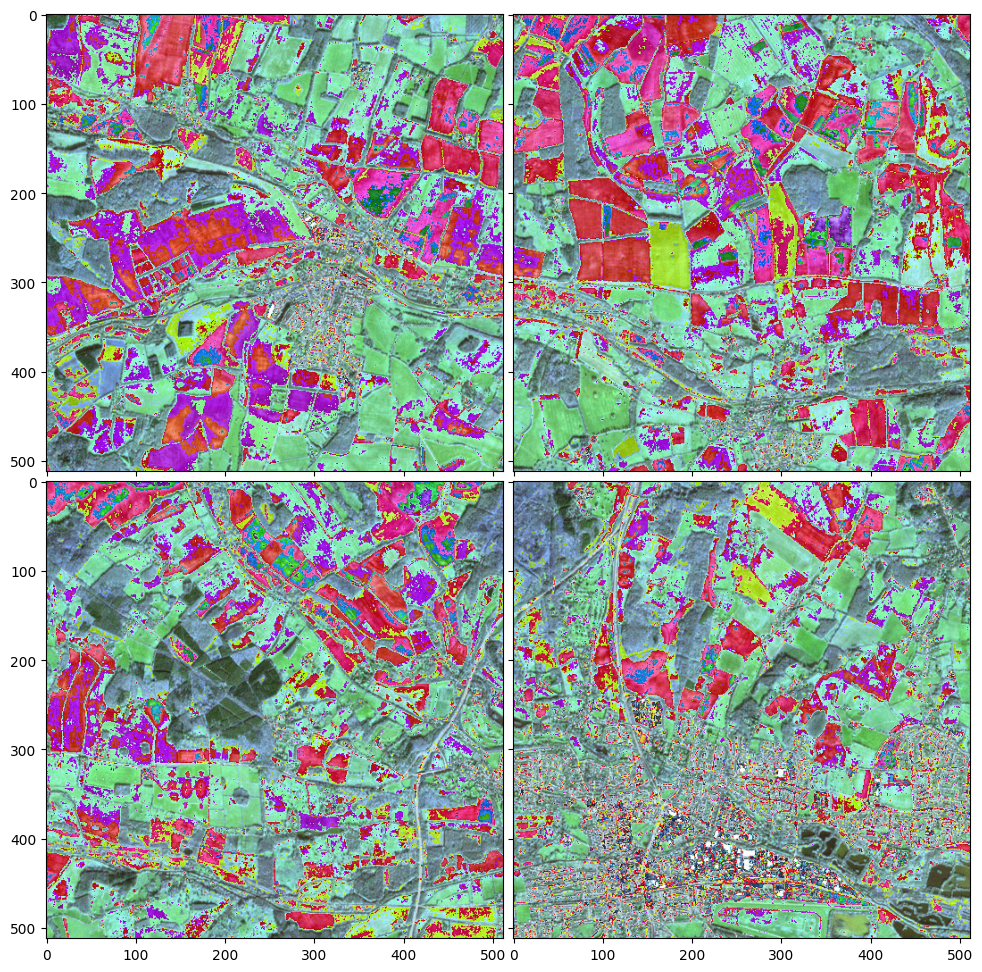

In [119]:
from mpl_toolkits.axes_grid1 import ImageGrid

patches = patches_img
fig = plt.figure(figsize=(12, 12))
grid = ImageGrid(fig, 111,  
                 nrows_ncols=(2, 2),  # 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [patches[0], patches[1], patches[2], patches[3]]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im*3)

plt.show()

In [107]:
(patches[0] != image[:512, :512, :]).sum()

0

In [26]:
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling, calculate_default_transform

dst_crs = "EPSG:3857"  # web mercator(ie google maps)

with rasterio.open(tif_path) as src:

    # transform for input raster
    src_transform = src.transform

    # calculate the transform matrix for the output
    dst_transform, width, height = calculate_default_transform(
        src.crs,    # source CRS
        dst_crs,    # destination CRS
        src.width,    # column count
        src.height,  # row count
        *src.bounds,  # unpacks outer boundaries (left, bottom, right, top)
    )

print("Source Transform:\n",src_transform,'\n')
print("Destination Transform:\n", dst_transform)

Source Transform:
 | 0.10, 0.00, 2669000.00|
| 0.00,-0.10, 1260000.00|
| 0.00, 0.00, 1.00| 

Destination Transform:
 | 0.15, 0.00, 929965.60|
| 0.00,-0.15, 6021954.00|
| 0.00, 0.00, 1.00|


# Pyproj

I guess what Alexey wanted falls in this category: https://pyproj4.github.io/pyproj/stable/build_crs.html

In [66]:
from pyproj.transformer import TransformerGroup
tg = trans_group = TransformerGroup(inputEPSG, outputEPSG)

In [70]:
tg.transformers[0]

<Concatenated Operation Transformer: pipeline>
Description: Inverse of UTM zone 30N + Inverse of CH1903+ to WGS 84 (1) + Swiss Oblique Mercator 1995
Area of Use:
- name: Liechtenstein; Switzerland.
- bounds: (5.96, 45.82, 10.49, 47.81)